In [1]:
%matplotlib inline
import scipy as sp, numpy as np
from scipy.optimize import least_squares
from scipy.stats import ttest_ind, zscore
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import LeaveOneGroupOut, LeaveOneOut
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import copy
import time

# Format Data


X-Data

In [2]:
# Import Data
X0 = sp.io.loadmat('X48_0T.mat')['X_data_0T'] # load raw gene data with 0 for missing values

In [3]:
# Fill missing data with averages
def Average_Genes(X):
    # Return X with missing values averaged across columns
    X_avg = copy.deepcopy(X)
    num_col = len(X[0, :])
    num_row = len(X[:, 0])
    for col in range(num_col): # columns
        Num_NonZero = 0
        for row in range(num_row): # rows
            if X[row, col] == 0:
                Num_NonZero = Num_NonZero + 1
        if Num_NonZero != 25:
            Row_Avg = np.mean(X[:,col])*25/(25-Num_NonZero)

            for row in range(num_row): # rows
                if X[row, col] == 0:
                    X_avg[row, col] = Row_Avg;
    return X_avg

X_avg = Average_Genes(X0);

In [4]:
# Remove Non-Genes
X_avg = X_avg[:, 0:41000]
X0 = X0[:, 0:41000]

In [5]:
'''Not Used'''
# Search for Nan in X_avg
def Find_nan(X):
    for col in range(len(X[0,:])):
        for row in range(len(X[:,0])):
            if np.isnan(X[row, col] is True):
                print(row, col)
#Find_nan(X_avg)

Y-Data

In [6]:
# Load T data
Y = sp.io.loadmat('Y48_T.mat')['Y_data_T']

In [7]:
# Split Y Data
Time48 = Y[:, 0] # measurement time
Dose48 = Y[:,1] # radiation exposure in Gray
Patients48 = Y[:, 2]; # patient number

Reporter List

In [8]:
get_reporters = True
if get_reporters is True:
    t = time.time()

    Genes = pd.read_excel('BE188_Data.xlsx', sheet_name='Genes')
    #print(np.shape(Genes))
    Genes_T = np.transpose(Genes)

    elapsed = time.time() - t
    print('%f seconds elapsed' %elapsed)

29.870767 seconds elapsed


In [9]:
# Get Ensembl IDs (from Ensembl Biomart)
t = time.time()

Ensembl = pd.read_excel('Ensembl_IDs.xlsx', sheet_name='v1_prove')
# print(Ensembl)
elapsed = time.time() - t
print('%f seconds elapsed' %elapsed)

16.198331 seconds elapsed


# Full Dataset

Percent Variance

In [10]:
def Normalize(X, Y):
    zero_column = np.zeros(25)
    Xnorm = np.zeros((len(X[:,0]), len(X[0,:])))
    for col in range(len(X[0,:])):
        X_list = X[:,col].tolist() # so that we can use the count function
        if np.sum(X[:,col]) != 0 and len(X_list) != X_list.count(X_list[0]):
            Xnorm[:,col] = zscore(X[:,col])  # normalize the X data . This zscores the genes
    Ynorm = zscore(Y)  # normalize the Y data
    return Xnorm, Ynorm

def Plt_Variance(X, Y, num_components, title = 'Variance Explained', returnVariance = False):
    Xnorm, Ynorm = Normalize(X, Y)
    variance_array = np.zeros(num_components) # calculate variance with different numbers of PLSR
    for i in range(1,num_components+1):
        plsr = PLSRegression(n_components = i) # go for 10
        plsr.fit(Xnorm, Ynorm)
        variance_array[i-1] = 100*plsr.score(Xnorm,Ynorm)
    plt.scatter(range(1,num_components+1),variance_array, color = 'k')
    plt.title(title)
    plt.xlabel("Num Principal Components")
    plt.ylabel("Percent Variance Explained")
    plt.show()
    if returnVariance is True:
        return variance_array

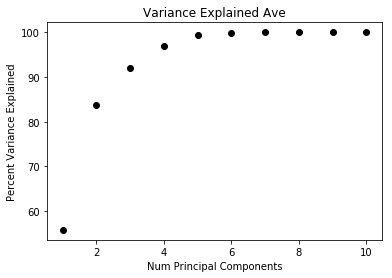

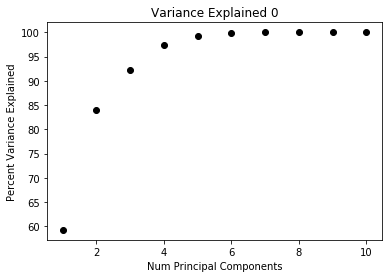

In [11]:
Plt_Variance(X_avg, Dose48, 10, returnVariance = False, title = 'Variance Explained Ave');
Plt_Variance(X0, Dose48, 10, returnVariance = False, title = 'Variance Explained 0');

Print Scores

In [12]:
# Setup PLSR for scores
def Plt_Scores(X, Y, xbound = None, ybound = None, save = False):
    # input unnormalized data
    
    Xnorm, Ynorm = Normalize(X, Y)
    plsrScore = PLSRegression(n_components = 2)
    plsrScore.fit(Xnorm,Ynorm)
    scores = plsrScore.x_scores_ 

    # Plot scores
    Doses = [0, 0.5, 2, 5, 8]
    iDoses = ['i0','i0_5', 'i2', 'i5', 'i8']
    colors = ['tab:blue', 'tab:green', 'gold', 'tab:orange', 'tab:red']
    
    fig, axs = plt.subplots(figsize = (7,7))
    for i, dose in enumerate(Doses):
        iDoses[i] = np.where(Dose48 == Doses[i])[0] # Get indices of each dosage
        plt.scatter(scores[iDoses[i],0],scores[iDoses[i],1], c = colors[i], label = Doses[i]) # plot scores by radiation level

    # Format plot
    plt.legend(title = 'Gray', loc = 'lower right')
    plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    plt.title('Scores')
    plt.xlim(xbound)
    plt.ylim(ybound)
    #axs.set_aspect('equal')
    if save is True:
        plt.savefig('Scores.png', bbox_inches = 'tight')

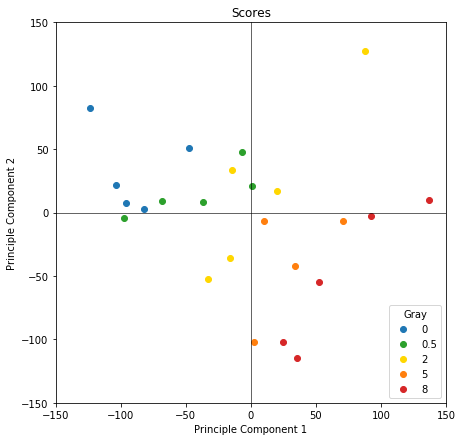

In [13]:
Plt_Scores(X_avg, Dose48, xbound = (-150, 150), ybound = (-150, 150), save = False)

Plot Loadings

In [14]:
def Plt_Loadings(X, Y, xbound = None, ybound = None, save = False, size = 0.05):
    # input unnormalized data
    
    Xnorm, Ynorm = Normalize(X, Y)
    plsrScore = PLSRegression(n_components = 2)
    plsrScore.fit(Xnorm,Ynorm)
    loadings = plsrScore.x_loadings_ 

    # Identify high and low values (can be cut from code)
    count1 = 0
    count2 = 0
    To = 0.003
    i_high_rad = np.zeros(20000)
    i_low_rad = np.zeros(20000)
    for k in range(len(loadings[:,0])):
        if (loadings[k,0] > To) and (loadings[k,1] < -To):
            i_high_rad[count1] = k
            count1 += 1
        elif (loadings[k,0] < -To) and (loadings[k,1] > To):
            i_low_rad[count2] = k
            count2 += 1
        else:
            pass
    i_high_rad = np.trim_zeros(i_high_rad, trim = 'b').astype(int)
    i_low_rad = np.trim_zeros(i_low_rad, trim = 'b').astype(int)
    
    # Plot loadings
    marksize = size
    fig, axs = plt.subplots(figsize = (7,7))
    #plt.scatter(loadings[i_high_rad, 0], loadings[i_high_rad, 1], s = marksize*1.5, color = 'red')
    #plt.scatter(loadings[i_low_rad, 0], loadings[i_low_rad, 1], s = marksize*1.5, color = 'blue')
    plt.scatter(loadings[:,0],loadings[:,1], s = marksize, color = 'k')    
    #plt.scatter(loadings[Sig_indices, 0], loadings[Sig_indices, 1], s = marksize+0.1, color = 'r')
    
    # Format plot
    plt.axhline(y = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.axvline(x = 0, color = 'k', linestyle = '-', linewidth = 0.6)
    plt.xlabel('Principle Component 1')
    plt.ylabel('Principle Component 2')
    plt.title('Original Loadings')
    plt.xlim(xbound)
    plt.ylim(ybound)
    axs.set_aspect('equal')
    if save is True:
        plt.savefig('Loadings_Non-significant.png', bbox_inches = 'tight')

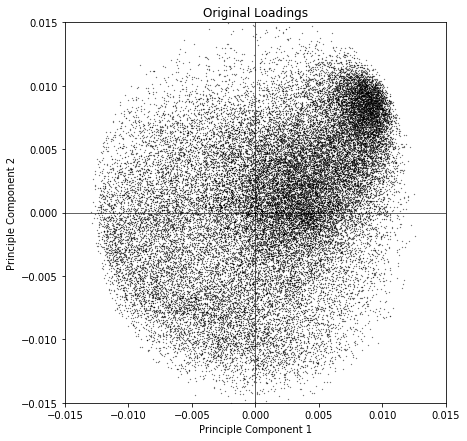

In [15]:
Plt_Loadings(X_avg, Dose48, xbound = (-0.015, 0.015), ybound = (-0.015, 0.015), save = False)

Cross Validation

In [116]:
def R_squared(Ymod, Yobs):
    # Calculate R^2 based on difference between predicted and observed Y values
    R_2 = 1 - np.sum((Ymod-Yobs)**2)/np.sum(Yobs**2)
    #print('R squared = %.7f' % R_2) 
    
def CV(Y, Average = True, X = X0, num_components = 8, reduce = False, diff_thresh = 8):
    loo = LeaveOneOut()
    StanScale = StandardScaler()

    # Get Y predicted for variable number of components
    Ypredicted = np.zeros((len(X[:,0]),num_components))
    R2_array = np.zeros(num_components)
    n = 0
    for c in range(1,num_components+1):
        plsr = PLSRegression(n_components=c)
        for train_index, test_index in loo.split(X):
            Xtrain = X[train_index]
            Ytrain = Y[train_index]
            X2 = X
            
            if Average is True: # average X
                Xtrain = Average_Genes(Xtrain)
            if reduce is True: # reduce dataset based on genes differentially expressed
                Sig_indices = T_test_reduce(Xtrain, Ytrain, p_thresh = 0.05, diff_thresh = diff_thresh)
                Xtrain = Xtrain[:, Sig_indices]
                X2 = X[:, Sig_indices]
                
            Xtrain_norm = StanScale.fit_transform(Xtrain)
            Ytrain_norm = zscore(Ytrain)
            plsr.fit(Xtrain_norm,Ytrain_norm)
            Ypredicted[n,c-1] = plsr.predict(StanScale.transform(X2[test_index]))
            n += 1
        R2_array[c-1] = r2_score(zscore(Y), Ypredicted[:, c-1])
        n = 0
    return Ypredicted, R2_array
    
def Plot_Msmnt_vs_Prdct(YpredictLOO, Y):
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(YpredictLOO, Y, color = 'k')
    plt.xlabel('Predicted Data')
    plt.ylabel('Measured Data');

In [134]:
t = time.time() # add tic toc to diagnose how long this code takes

Ypredicted_Full, R2_array_Full = CV(Dose48, Average = False, num_components = 8) # Average = True takes a few minutes

elapsed = time.time() - t
print('%f seconds elapsed' %elapsed)

36.698980 seconds elapsed


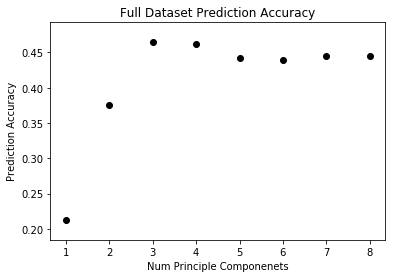

In [136]:
# Plot full dataset prediction accuracy
plt.scatter(range(1,9), R2_array_Full, color = 'k')
plt.title('Full Dataset Prediction Accuracy')
plt.xlabel('Num Principle Componenets')
plt.ylabel('Prediction Accuracy');
#plt.savefig('Full_Data_R2CV', bbox_inches = 'tight')

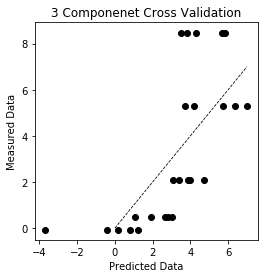

In [165]:
# Plot full dataset measrued vs predicted
Plot_Msmnt_vs_Prdct(8/2.49*(Ypredicted_Full[:, 2]+1.01), 8/2.49*(zscore(Dose48)+1.01))
plt.title('3 Componenet Cross Validation');
plt.plot((0,7), (0,7), linestyle = '--', color = 'k', linewidth = 0.8);
#plt.savefig('Full_DataMsrvsPrd', bbox_inches = 'tight')

# Reduced Data

T-Test Data to identify significant genes

In [105]:
def T_test_reduce(X, Y, p_thresh = 0.05, diff_thresh = 8, comparison = '<='):
    # Returns indices of important genes
    
    # Get indices of each dose
    Doses = [0, 0.5, 2, 5, 8]
    iDoses = ['i0','i0_5', 'i2', 'i5', 'i8']
    for i, dose in enumerate(Doses):
        iDoses[i] = np.where(Y == Doses[i])[0] # Get indices of each dosage

    # Compare expression of each gene across doses
    sig_cols = np.zeros(len(X[0,:]))
    count_sig_cols = 0

    for col in range(len(X[0,:])): # go through all columns

        count_sig_p = 0

        # Identify significant comparisons
        for start in range(len(Doses)-1):
            for num in range(start+1, len(Doses)):
                dist1 = X[iDoses[start], col]
                dist2 = X[iDoses[num], col]
                p_value = ttest_ind(dist1, dist2)[1]
                if p_value < p_thresh:
                    count_sig_p += 1
                    
        # Tally significance
        if comparison == '>=':
            if count_sig_p >= diff_thresh: # if gene is differentially expressed across all but 10-'diff_thresh' radiation levels
                sig_cols[count_sig_cols] = col
                count_sig_cols += 1
        elif comparison == '<=':
            if count_sig_p <= diff_thresh: # if gene is differentially expressed across 'diff_thresh' or fewer radiation levels
                sig_cols[count_sig_cols] = col
                count_sig_cols += 1

    sig_cols_out = np.trim_zeros(sig_cols, trim = 'b').astype(int) # remove trailing zeros
    #np.save('Ttest_4Sig.npy', sig_cols)
    return sig_cols_out

Remove non-significant genes

In [109]:
# Remove genes with 0% probability of becoming significant
# Changing one radiation level can change at most 4 comparisons
# Fewer than 4 significant comparisons could never become significant if the threshold for being considered 'important' >= 8

t = time.time() # add tic toc to diagnose how long this code takes

Sig_indices = T_test_reduce(X_avg, Dose48, p_thresh = 0.05, diff_thresh = 3, comparison = '>=')

elapsed = time.time() - t
print('%f seconds elapsed' %elapsed)

97.214602 seconds elapsed


In [127]:
# Analyze and save reduced datasets indices
analyze = False
if analyze is True:
    print(np.shape(Sig_indices))
    print(Sig_indices)
#np.save('iMin4Sig.npy', Sig_indices)

Assign IDs to significant genes for PANTHER

In [23]:
# Get subset of significant genes
Sig8 = np.load('iMin8Sig.npy')
SigGenes = Genes_T[Sig8]
SigGenes_T = np.transpose(SigGenes)
SigGenes_T.to_excel('SigGenes.xlsx') # save to excel for easier formatting
# excel file was formatted to give it the same headings as the Ensembl dataframe and resaved as SigGenesFormatted
#print(SigGenes)

In [24]:
# Reload Agilent IDs in same format as Ensembl
SigAgilent = pd.read_excel('SigGenesFormatted.xlsx', sheet_name='8Sig')

# Remove Agilent and Ensembl dataframes
EnsemblVal = Ensembl.values
AgilentVal = SigAgilent.values

# Assign Ensembl IDs to significant Agilent IDs
for iAg in range(len(AgilentVal[:, 2])):
    for iEn in range(len(EnsemblVal[:, 2])):
        if AgilentVal[iAg, 2] == EnsemblVal[iEn, 2]:
            AgilentVal[iAg, 0] = EnsemblVal[iEn, 0]

In [26]:
# Save Ensembl IDs of Significant Genes to enter into PANTHER
SigEnsembl = AgilentVal[:, 0]
#pd.DataFrame(SigEnsembl).to_csv("SigEnsembl.csv", header = None, index = None)

Rerun with reduced data

In [115]:
# Load dataset with only genes that could be significant
Sig4 = np.load('iMin4Sig.npy')
X4sig = X_avg[:, Sig4]
X4sig0 = X0[:, Sig4]
print(X4sig.shape)

(25, 1206)


"Sig4 = np.load('Ttest_4Sig.npy')\nprint(np.shape(Sig4))\nX4sig = X_avg[:, Sig4]\nX4sig0 = X0[:, Sig4]"

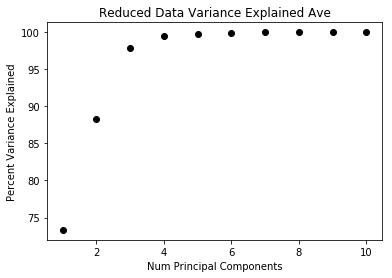

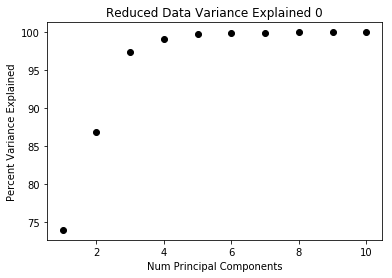

In [111]:
# Plot percent variance explained
Plt_Variance(X4sig, Dose48, 10, returnVariance = False, title = 'Reduced Data Variance Explained Ave')
Plt_Variance(X4sig0, Dose48, 10, returnVariance = False, title = 'Reduced Data Variance Explained 0')

In [135]:
# Plot cross validation R^2
# Running cross validation on a dataset reduced to not include any gene that our t-test within 
# cross validation could not possibly identify as significant
run_reduced_CV = True
if run_reduced_CV is True:
    t = time.time()

    Ypredicted_Red, R2_array_Red = CV(Dose48, Average = False, X = X4sig, num_components = 8, reduce = True)

    elapsed = time.time() - t
    print('%f seconds elapsed' %elapsed)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in l

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in l

904.418305 seconds elapsed


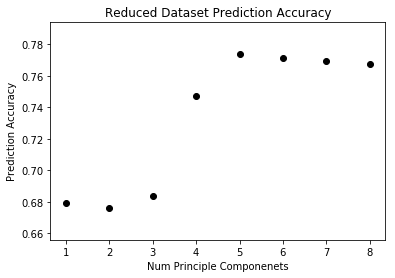

In [138]:
plt.scatter(range(1,9), R2_array_Red, color = 'k')
plt.title('Reduced Dataset Prediction Accuracy')
plt.xlabel('Num Principle Componenets')
plt.ylabel('Prediction Accuracy');
#plt.savefig('Reduced_Dataset_Prediciton_Accuracy')

#print(R2_array)

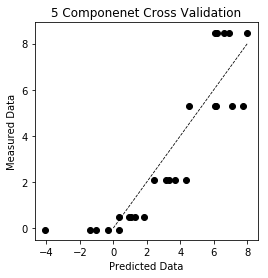

In [161]:
# Plot observation vs prediction
Plot_Msmnt_vs_Prdct(8/2.49*(zscore(Ypredicted_Red[:, 4])+1.01), 8/2.49*(zscore(Dose48)+1.01))
plt.plot((0,8), (0,8), linestyle = '--', color = 'k', linewidth = 0.8)

plt.title('5 Componenet Cross Validation');

#plt.savefig('Reduced_Data_MsrvsPrd', bbox_inches = 'tight')

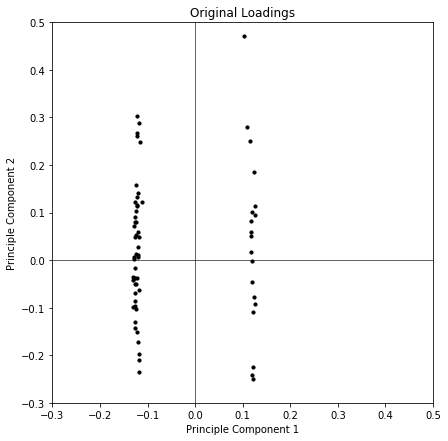

In [31]:
# Plot Loadings
Plt_Loadings(X4sig, Dose48, size = 10, xbound = (-0.3, 0.5), ybound= (-0.3, 0.5))
#plt.savefig('Reduced_Data_loadings', bbox_inches = 'tight')

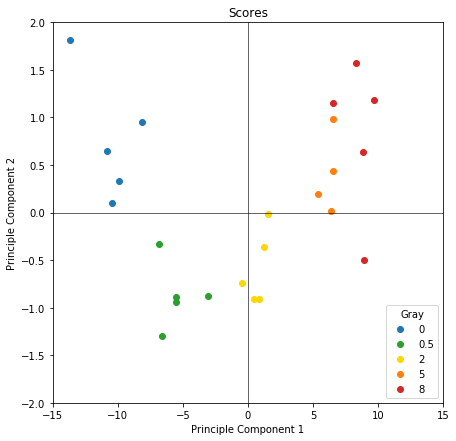

In [32]:
# Plot Loadings
Plt_Scores(X4sig, Dose48, ybound = (-2,2), xbound = (-15,15), save = False)
#plt.savefig('Reduced_data_scores', bbox_inches = 'tight')

# Comparisons

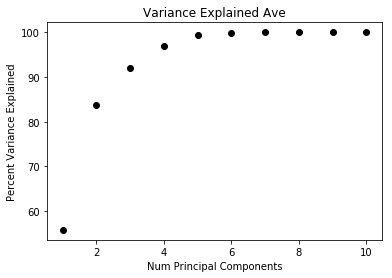

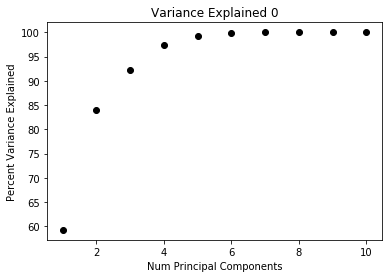

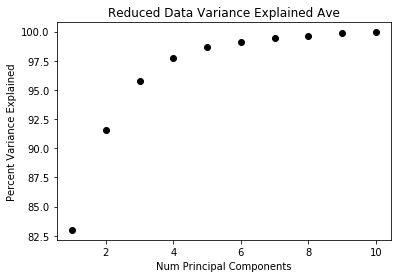

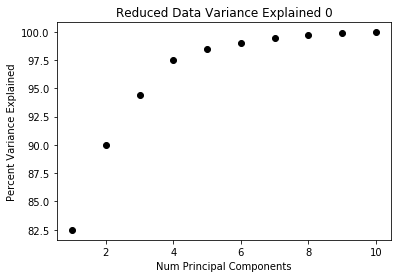

In [41]:
FullVarianceAve = Plt_Variance(X_avg, Dose48, 10, returnVariance = True, title = 'Variance Explained Ave');
FullVariance0 = Plt_Variance(X0, Dose48, 10, returnVariance = True, title = 'Variance Explained 0');
ReducedVarianceAve = Plt_Variance(X4sig, Dose48, 10, returnVariance = True, title = 'Reduced Data Variance Explained Ave')
ReducedVariance0 = Plt_Variance(X4sig0, Dose48, 10, returnVariance = True, title = 'Reduced Data Variance Explained 0')

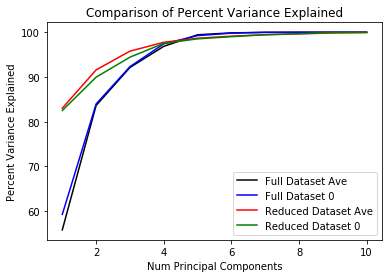

In [47]:
num_components = 10
plt.plot(range(1,num_components+1),FullVarianceAve, color = 'k', label = 'Full Dataset Ave')
plt.plot(range(1,num_components+1),FullVariance0, color = 'b', label = 'Full Dataset 0')
plt.plot(range(1,num_components+1),ReducedVarianceAve, color = 'r', label = 'Reduced Dataset Ave')
plt.plot(range(1,num_components+1),ReducedVariance0, color = 'g', label = 'Reduced Dataset 0')
plt.legend()
plt.title('Comparison of Percent Variance Explained')
plt.xlabel("Num Principal Components")
plt.ylabel("Percent Variance Explained");
#plt.savefig('Percent_Variance_Comparison', bbox_inches = 'tight')

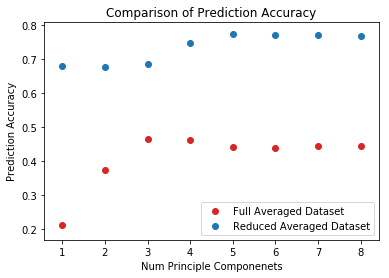

In [164]:
num_componenets = 8
plt.scatter(range(1, num_componenets+1), R2_array_Full, color = 'tab:red', label = 'Full Averaged Dataset')
plt.scatter(range(1, num_componenets+1), R2_array_Red, color = 'tab:blue', label = 'Reduced Averaged Dataset')
plt.legend()
plt.title('Comparison of Prediction Accuracy') # currently with non-averaged
plt.xlabel('Num Principle Componenets')
plt.ylabel('Prediction Accuracy');
#plt.savefig('Prediction_Accuracy_Comparsion', bbox_inches = 'tight')